## Core concepts

In [64]:
%load_ext autoreload
%autoreload 2
import summarization_interface
from summarization_interface import Material, get_idf_value, normalize_word, Default_IDF_Value, LinkType
from pathlib import Path
mainMaterial = Material((Path(r'H:\2024_03_05课程大纲\数据\syllabus\wsln_min') / 'rsm.triplets'), 'rsm')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


loading rsm: 100%|██████████| 141/141 [00:00<00:00, 347.04it/s]


In [140]:
# 对比TFIDF, 在前50%占比情况，词跨度, action_link_count
import re

tf, tf_idf, front, _span, action_counter, incoming_action_counter = {}, {}, {}, {}, {}, {}
for sentence_index, sentence in enumerate(mainMaterial.sentences):
    for word in sentence.words:
        if not re.match('[a-zA-Z]+', word):
            continue

        word = normalize_word(word)
        word = word.replace('-', '')

        if len(word) < 4:
            continue

        tf[word] = tf.get(word, 0) + 1
        tf_idf[word] = tf_idf.get(word, 0) + get_idf_value(word)

        if sentence_index < len(mainMaterial.sentences) / 2:
            front[word] = front.get(word, 0) + 1

        if word not in _span:
            _span[word] = [sentence_index, sentence_index]
        else:
            _span[word][1] = sentence_index

    for pre, ind, rtype, post, _ in sentence.links:
        if rtype == LinkType.Action:
            action_counter[pre] = action_counter.get(pre, 0) + 1
            incoming_action_counter[post] = incoming_action_counter.get(post, 0) + 1

span = {
    word: values[1] - values[0]
    for word, values in _span.items()
}

In [141]:
def _sort_norm(data_list, n):
    norm_data_list = []
    for data in data_list:
        norm_data = {}
        _max, _min = max(data.values()), min(data.values())
        for key, value in sorted(data.items(), key=lambda x: -x[1]):
            norm_data[key] = (value - _min) / (_max - _min)
        norm_data_list.append(norm_data)
        # _sort = lambda d, n: sorted(d.items(), key=lambda x: -x[1])[:n]

    common_top = set(norm_data_list[0].keys())
    for data in norm_data_list[1:]:
        common_top &= set(k for k in data)
    
    return norm_data_list, common_top

norms, common_top = _sort_norm([tf, tf_idf, front, span, action_counter, incoming_action_counter], 20)

# from functools import partial
# sort = partial(_sort, n = 20)

# sort(tf)
# sort(tf_idf)
# sort(front)
# sort(span)
# sort(action_counter)
# sort(incoming_action_counter)

In [142]:
# 找出公共的前20个词，证明action link的优势

norms, common_top = _sort_norm([tf, tf_idf, front, span, action_counter, incoming_action_counter], 20)

norm_tf, norm_tf_idf, norm_front, norm_span, norm_action_counter, norm_incoming_action_counter = norms


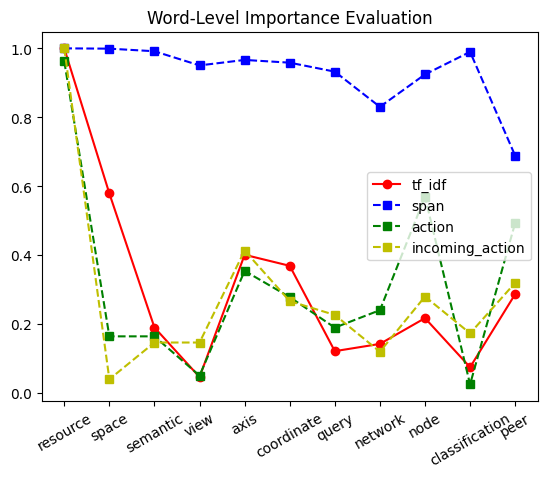

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# 生成横坐标数据
x = np.arange(0, 10, 1)

# TODO: 选一些例子，更能凸显action link的优势
# TODO: semantic node也可以计算frequency, span等 
core_words = [
    'resource',
    'space',
    'semantic',
    # 'link',
    'view',
    'axis',
    'coordinate',
    'query',
    'network',
    'node',
    'classification',
    'peer',
]

# 生成纵坐标数据
tf_idf_y = [norm_tf_idf[w] for w in core_words]
front_y = [norm_front[w] for w in core_words]
span_y = [norm_span[w] for w in core_words]
action_y = [norm_action_counter[w] for w in core_words]
incoming_action_y = [norm_incoming_action_counter[w] for w in core_words]

y1 = np.sin(x)
y2 = np.cos(x)

# 绘制第一条折线
plt.plot(core_words, tf_idf_y, color='r', marker='o', linestyle='-', label='tf_idf')
# 绘制第二条折线
plt.plot(core_words, span_y, color='b', marker='s', linestyle='--', label='span')
plt.plot(core_words, action_y, color='g', marker='s', linestyle='--', label='action')
plt.plot(core_words, incoming_action_y, color='y', marker='s', linestyle='--', label='incoming_action')

# 添加图例
plt.legend()

plt.xticks(rotation=30)

# 设置x轴标签
# plt.xlabel('x')
# 设置y轴标签
# plt.ylabel('y')
# 设置标题
plt.title('Word-Level Importance Evaluation')

plt.savefig('figs/word_level_importance.png', dpi=300, bbox_inches='tight')


# 显示图形
plt.show()


In [25]:
get_idf_value('finer'), Default_IDF_Value

(4.33, 7.513607609220388)

## Phrase level Figure

In [145]:
# 对比TFIDF, 在前50%占比情况，词跨度, action_link_count
import re

phrase_tf, phrase_tf_idf, phrase_front, _phrase_span, phrase_action_counter, phrase_incoming_action_counter = {}, {}, {}, {}, {}, {}
for sentence_index, sentence in enumerate(mainMaterial.sentences):
    phrases = set()
    for pre, ind, rtype, post, _ in sentence.links:
        phrases.update([pre, ind, post])

        if rtype == LinkType.Action:
            phrase_action_counter[pre] = phrase_action_counter.get(pre, 0) + 1
            phrase_incoming_action_counter[post] = phrase_incoming_action_counter.get(post, 0) + 1
    
    for phrase in phrases:
        if len(phrase) < 4:
            continue

        phrase = ' '.join([normalize_word(word) for word in phrase.split(' ')])

        phrase_tf[phrase] = phrase_tf.get(phrase, 0) + 1
        phrase_tf_idf[phrase] = phrase_tf.get(phrase, 0) + get_idf_value(phrase)

        # 前20%
        if sentence_index < len(mainMaterial.sentences) / 5:
            phrase_front[phrase] = phrase_front.get(phrase, 0) + 1
        
        if phrase not in _phrase_span:
            _phrase_span[phrase] = [sentence_index, sentence_index]
        else:
            _phrase_span[phrase][1] = sentence_index


    for pre, ind, rtype, post, _ in sentence.links:
        if rtype == LinkType.Action:
            action_counter[pre] = action_counter.get(pre, 0) + 1
            incoming_action_counter[post] = incoming_action_counter.get(post, 0) + 1

phrase_span = {
    word: values[1] - values[0]
    for word, values in _phrase_span.items()
}

In [146]:
(norm_phrase_tf, norm_phrase_tf_idf, norm_phrase_front, norm_phrase_span, norm_phrase_action_counter, norm_phrase_incoming_action_counter), common_top = _sort_norm([phrase_tf, phrase_tf_idf, phrase_front, phrase_span, phrase_action_counter, phrase_incoming_action_counter], 20)


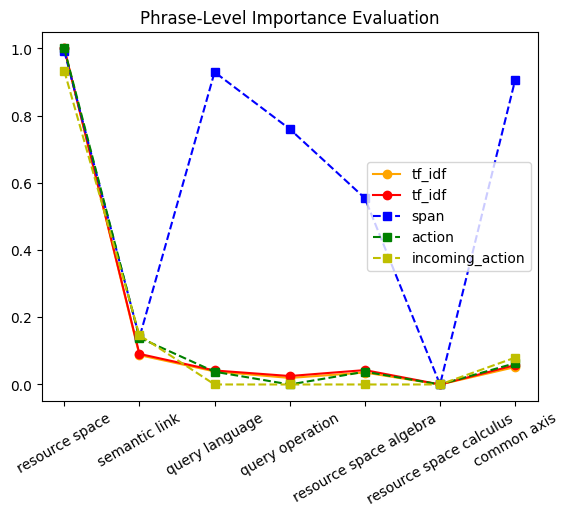

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# 生成横坐标数据
x = np.arange(0, 10, 1)

# TODO: 选一些例子，更能凸显action link的优势
# TODO: semantic node也可以计算frequency, span等 
core_words = [
    # 'rsm',
    # 'semantic link network',
    'resource space',
    'semantic link',
    'query language',
    # 'relational tables',
    # 'union view',
    # 'resource class hierarchy',
    'query operation',
    'resource space algebra',
    'resource space calculus',
    'common axis',
    # 'critical dimension',
    # 'resource space model storage',
    # 'rsm storage',
    # 'gossip network',
    # 'point query',
    # 'resource query',
    # 'resource modification',
    # 'probabilistic resource space',
]

# 生成纵坐标数据
tf_y = [norm_phrase_tf.get(w, 0) for w in core_words]
tf_idf_y = [norm_phrase_tf_idf.get(w, 0) for w in core_words]
front_y = [norm_phrase_front.get(w, 0) for w in core_words]
span_y = [norm_phrase_span.get(w, 0) for w in core_words]
action_y = [norm_phrase_action_counter.get(w, 0) for w in core_words]
incoming_action_y = [norm_phrase_incoming_action_counter.get(w, 0) for w in core_words]


# 绘制第一条折线
plt.plot(core_words, tf_y, color='orange', marker='o', linestyle='-', label='tf_idf')
plt.plot(core_words, tf_idf_y, color='r', marker='o', linestyle='-', label='tf_idf')
# 绘制第二条折线
plt.plot(core_words, span_y, color='b', marker='s', linestyle='--', label='span')
plt.plot(core_words, action_y, color='g', marker='s', linestyle='--', label='action')
plt.plot(core_words, incoming_action_y, color='y', marker='s', linestyle='--', label='incoming_action')

plt.xticks(rotation=30)

# 添加图例
plt.legend()

# 设置x轴标签
# plt.xlabel('x')
# 设置y轴标签
# plt.ylabel('y')
# 设置标题
plt.title('Phrase-Level Importance Evaluation')

plt.savefig('figs/phrase_level_importance.png', dpi=300, bbox_inches='tight')


# 显示图形
plt.show()

In [104]:
sorted(norm_action_counter.items(), key=lambda x: -x[1])[:30]

[('resource space', 1.0),
 ('resource', 0.9620253164556962),
 ('node', 0.569620253164557),
 ('peer', 0.4936708860759494),
 ('operation', 0.3924050632911392),
 ('user', 0.379746835443038),
 ('axis', 0.35443037974683544),
 ('coordinate', 0.27848101265822783),
 ('person', 0.24050632911392406),
 ('network', 0.24050632911392406),
 ('one', 0.22784810126582278),
 ('chapter', 0.20253164556962025),
 ('query', 0.189873417721519),
 ('example', 0.17721518987341772),
 ('semantic', 0.16455696202531644),
 ('space', 0.16455696202531644),
 ('point', 0.16455696202531644),
 ('theorem', 0.16455696202531644),
 ('system', 0.1518987341772152),
 ('tree', 0.1518987341772152),
 ('approach', 0.13924050632911392),
 ('application', 0.13924050632911392),
 ('semantic link', 0.13924050632911392),
 ('external relationship', 0.13924050632911392),
 ('object', 0.12658227848101267),
 ('best algorithm', 0.12658227848101267),
 ('neighbor', 0.12658227848101267),
 ('resource indice', 0.12658227848101267),
 ('designer', 0.1139

{'ability',
 'abstraction',
 'advantage',
 'algorithm',
 'answer',
 'application',
 'application scope',
 'approach',
 'area',
 'attribute',
 'authority',
 'axis',
 'axis name',
 'book',
 'case',
 'category',
 'cave content',
 'check clause',
 'citation relation',
 'classification',
 'classification method',
 'classification semantic',
 'clause',
 'common ancestor',
 'common axis',
 'community',
 'comparison',
 'complex object',
 'computer',
 'concept',
 'consistency',
 'content',
 'coordinate',
 'coordinate setting',
 'coordinate tree',
 'customer',
 'database',
 'datum',
 'definition',
 'designer',
 'different category',
 'different classification method',
 'dimension',
 'disk',
 'domain ontology',
 'effect',
 'efficiency',
 'eleven category',
 'example',
 'existing resource space',
 'experience',
 'external feature',
 'fig.1.16',
 'file',
 'following abstract concept',
 'following command',
 'following statement',
 'four operation',
 'function',
 'good',
 'human behavior mode',
 'id

In [ ]:
# TODO: 按照tf排列所有的词，然后绘制不同方法的曲线，看重合度，如何利用上不同方法的优势？




phrase